In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from time import time
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('Cole_2018.mplstyle')

from neurodsp.sim import sim_noisy_bursty_oscillator
from neurodsp.filt import filter_signal
from bycycle.features import compute_features

from config import config_sim

# Simulate data

In [3]:
# Define simulation parameters
n_seconds = 300
fs = config_sim['fs']

features_dict = defaultdict(list)
lfps = []
lfps_filt = []
dfs_shape = []
dfs_shape_cycles = []
oscillators = []
all_snr = np.logspace(-1, 1, 41)
start_time = time()

cycle_features = {'amp_std': .2,
                  'period_std': 15,
                  'rdsym_std': .1}

np.random.seed(0)
for snr in all_snr:
    # Simulate signal
    lfp, oscillator, brown, df_shape_true = sim_noisy_bursty_oscillator(
        n_seconds, fs, config_sim['freq_osc'],
        'filtered_powerlaw',
        {'exponent':config_sim['exponent'], 'f_range':config_sim['f_range_noise'], 'filter_order':config_sim['filter_order_noise']},
        ratio_osc_var=snr,
        prob_enter_burst=config_sim['prob_enter_burst'],
        prob_leave_burst=config_sim['prob_leave_burst'],
        cycle_features=cycle_features,
        return_cycle_df=True, return_components=True)

    # Apply lowpass filter
    lfp_filt = filter_signal(lfp, fs, 'lowpass', fc=config_sim['lowpass_fc'],
                             n_seconds=config_sim['lowpass_n_seconds'],
                             remove_edge_artifacts=False, verbose=False)

    # Decompose signal into cycles
    df_shape = compute_features(lfp_filt, fs, config_sim['f_range'], center_extrema='P',
                                burst_detection_kwargs=config_sim['osc_detect_kwargs'])

    # Define ground truth for oscillating for each cycle based on known simulation
    is_cycle_true = []
    for i, row in df_shape.iterrows():
        is_cycle_true.append(df_shape_true[df_shape_true['start_sample'] < row['sample_peak']].iloc[-1]['is_cycle'])
    df_shape['is_burst_true'] = is_cycle_true

    # Define ground truth for rdsym, amp, and period of each cycle
    df_shape_cycles = df_shape[df_shape['is_burst_true']]
    true_rdsym = []
    true_amp = []
    true_period = []
    for i, row in df_shape_cycles.iterrows():
        row_oi = df_shape_true[df_shape_true['start_sample'] < row['sample_peak']].iloc[-1]
        true_rdsym.append(row_oi['rdsym'])
        true_amp.append(row_oi['amp'])
        true_period.append(row_oi['period'])

    df_shape_cycles['rdsym_true'] = true_rdsym
    df_shape_cycles['rdsym_pred'] = df_shape_cycles['time_rdsym']
    df_shape_cycles['amp_true'] = np.array(true_amp) * 2
    df_shape_cycles['amp_pred'] = df_shape_cycles['volt_amp']
    df_shape_cycles['period_true'] = true_period
    df_shape_cycles['period_pred'] = df_shape_cycles['period']
    
    # Compute errors and average errors
    features_dict['snr'].append(snr)
    for feat in ['rdsym', 'amp', 'period']:
        df_shape_cycles[feat + '_error'] = np.abs(df_shape_cycles[feat+'_true'] - df_shape_cycles[feat+'_pred']) / df_shape_cycles[feat+'_true']
        avg_error = np.mean(df_shape_cycles[feat + '_error'])
        features_dict['avg_error_' + feat].append(avg_error)

    lfps.append(lfp)
    lfps_filt.append(lfp_filt)
    oscillators.append(oscillator)
    dfs_shape.append(df_shape)
    dfs_shape_cycles.append(df_shape_cycles)
    print('Done {:.0f} seconds : snr={:.2f}'.format(time() - start_time, snr))

df_features = pd.DataFrame(features_dict)

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

Done 9 seconds : snr=0.10
Done 17 seconds : snr=0.11
Done 26 seconds : snr=0.13
Done 34 seconds : snr=0.14
Done 43 seconds : snr=0.16
Done 52 seconds : snr=0.18
Done 60 seconds : snr=0.20
Done 69 seconds : snr=0.22
Done 77 seconds : snr=0.25
Done 86 seconds : snr=0.28
Done 94 seconds : snr=0.32
Done 102 seconds : snr=0.35
Done 111 seconds : snr=0.40
Done 120 seconds : snr=0.45
Done 128 seconds : snr=0.50
Done 137 seconds : snr=0.56
Done 145 seconds : snr=0.63
Done 154 seconds : snr=0.71
Done 163 seconds : snr=0.79
Done 171 seconds : snr=0.89
Done 180 seconds : snr=1.00
Done 189 seconds : snr=1.12
Done 197 seconds : snr=1.26
Done 206 seconds : snr=1.41
Done 215 seconds : snr=1.58
Done 224 seconds : snr=1.78
Done 232 seconds : snr=2.00
Done 241 seconds : snr=2.24
Done 249 seconds : snr=2.51
Done 258 seconds : snr=2.82
Done 267 seconds : snr=3.16
Done 275 seconds : snr=3.55
Done 284 seconds : snr=3.98
Done 292 seconds : snr=4.47
Done 300 seconds : snr=5.01
Done 309 seconds : snr=5.62
Done

# A-B. Comparison of true oscillator to result of lowpass filter

Signal 1 SNR = 0.32
Signal 2 SNR = 3.16


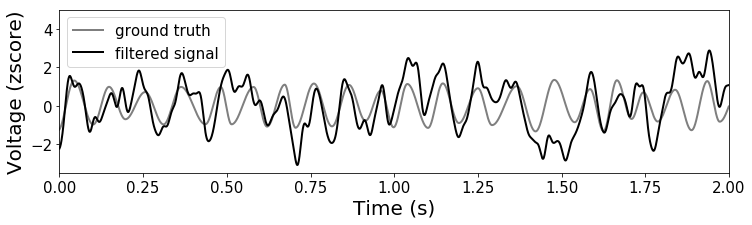

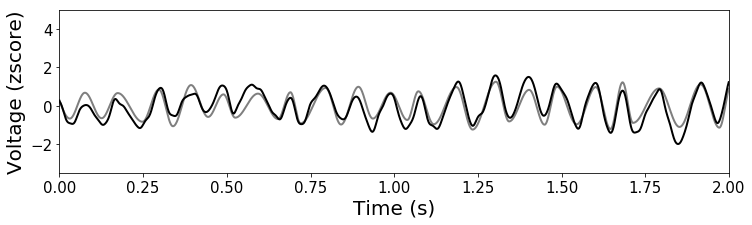

In [4]:
idx1 = 10
print('Signal 1 SNR = {:.2f}'.format(all_snr[idx1]))
idx2 = 30
print('Signal 2 SNR = {:.2f}'.format(all_snr[idx2]))

t = np.arange(0, len(lfps[0])/fs, 1/fs)
tlim = (37, 39)
tidx = np.logical_and(t >= tlim[0], t<tlim[1])

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], oscillators[idx1][tidx], 'k', alpha=.5, label='ground truth')
plt.plot(t[tidx] - tlim[0], lfps_filt[idx1][tidx], 'k', label='filtered signal')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-3.5, 5))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.legend(fontsize=15)
plt.savefig('figs/3A_Ground truth and recorded comparison.png', bbox_inches = "tight")

tlim = (9.2, 11.2)
tidx = np.logical_and(t >= tlim[0], t<tlim[1])

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], oscillators[idx2][tidx], 'k', alpha=.5, label='ground truth')
plt.plot(t[tidx] - tlim[0], lfps_filt[idx2][tidx], 'k', label='filtered signal')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-3.5, 5))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/3B_Ground truth and recorded comparison better.png', bbox_inches = "tight")

# C-H. Error in cycle feature estimation for example signals

True-measured amp    correlation: r=0.19, p = 6E-13
True-measured period correlation: r=0.25, p = 1E-21
True-measured rdsym  correlation: r=0.06, p = 3E-02


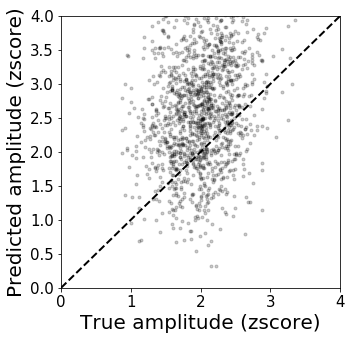

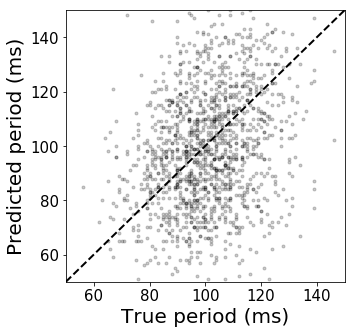

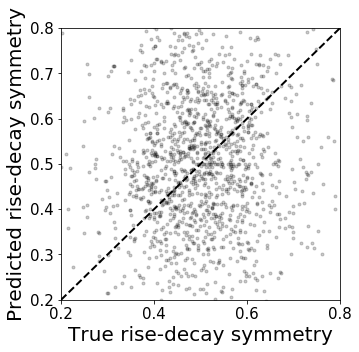

In [5]:
for feat, feat_name, letter, lims in zip(['amp', 'period', 'rdsym'],
                                  ['amplitude (zscore)', 'period (ms)', 'rise-decay symmetry'],
                                  ['C', 'D', 'E'],
                                  [(0, 4), (50, 150), (.2, .8)]):
    plt.figure(figsize=(5,5))
    plt.plot(dfs_shape_cycles[idx1][feat + '_true'], dfs_shape_cycles[idx1][feat + '_pred'], 'k.', alpha=.2)
    plt.plot(lims, lims, 'k--')
    plt.xlabel('True {:s}'.format(feat_name))
    plt.ylabel('Predicted {:s}'.format(feat_name))
    plt.xlim(lims)
    plt.ylim(lims)
    plt.savefig('figs/3{:s}_{:s} accuracy.png'.format(letter, feat_name), bbox_inches = "tight")
    
    # Correlation
    r, p = stats.pearsonr(dfs_shape_cycles[idx1][feat + '_true'], dfs_shape_cycles[idx1][feat + '_pred'])
    print('True-measured {:6s} correlation: r={:.2f}, p = {:.0E}'.format(feat, r, p))
    

True-measured amp    correlation: r=0.52, p = 2E-95
True-measured period correlation: r=0.46, p = 9E-75
True-measured rdsym  correlation: r=0.30, p = 5E-31


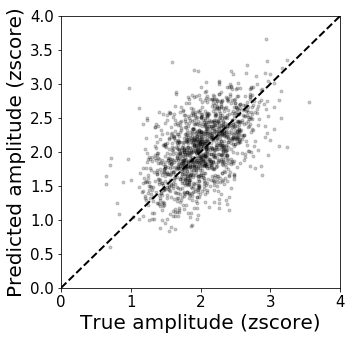

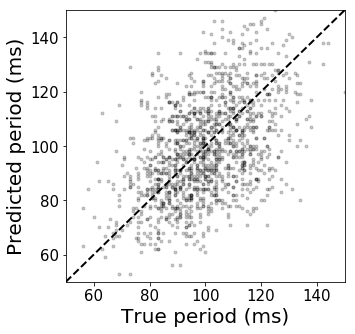

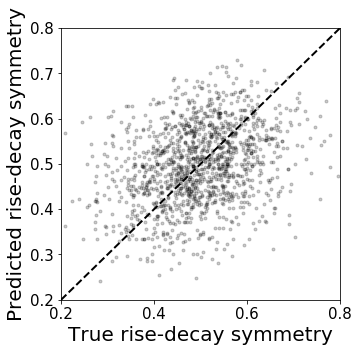

In [6]:
for feat, feat_name, letter, lims in zip(['amp', 'period', 'rdsym'],
                                  ['amplitude (zscore)', 'period (ms)', 'rise-decay symmetry'],
                                  ['F', 'G', 'H'],
                                  [(0, 4), (50, 150), (.2, .8)]):
    plt.figure(figsize=(5,5))
    plt.plot(dfs_shape_cycles[idx2][feat + '_true'], dfs_shape_cycles[idx2][feat + '_pred'], 'k.', alpha=.2)
    plt.plot(lims, lims, 'k--')
    plt.xlabel('True {:s}'.format(feat_name))
    plt.ylabel('Predicted {:s}'.format(feat_name))
    plt.xlim(lims)
    plt.ylim(lims)
    plt.savefig('figs/3{:s}_{:s} accuracy.png'.format(letter, feat_name), bbox_inches = "tight")
    
    # Correlation
    r, p = stats.pearsonr(dfs_shape_cycles[idx2][feat + '_true'], dfs_shape_cycles[idx2][feat + '_pred'])
    print('True-measured {:6s} correlation: r={:.2f}, p = {:.0E}'.format(feat, r, p))

# I. Average error across all recordings

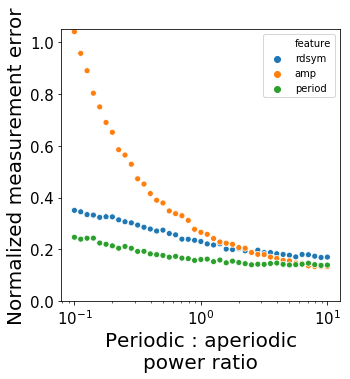

In [7]:
df_plt = df_features.melt(id_vars='snr', value_vars=df_features.filter(like='avg_error_').columns)
df_plt['variable'] = [s[10:] for s in df_plt['variable']]
df_plt.rename(columns={'variable': 'feature', 'value': 'avg_error'}, inplace=True)

plt.figure(figsize=(5,5))
sns.scatterplot(x='snr', y='avg_error', hue='feature', data=df_plt)
plt.gca().set_xscale('log')
plt.xlabel('Periodic : aperiodic\npower ratio')
plt.ylabel('Normalized measurement error')
plt.ylim((0, 1.05))
plt.savefig('figs/3I_Average accuracy.png', bbox_inches = "tight")